In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore') # Suppress skl k-NN param warnings 

from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

#import graphviz

In [3]:
# Read the data
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')
train

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,Female
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,Male
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,Male
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,Male
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,303,2398,1334.0,1166,5,1973,2,761,174.0,43.200000,31.000000,46.0,24.0,Male
1035,632,8404,1952.0,187,6,1992,2,5820,172.0,37.166667,24.000000,21.0,34.0,Female
1036,1326,2750,877.0,356,2,2000,3,547,53.0,27.500000,27.666667,28.0,25.0,Male
1037,462,3994,775.0,52,8,1996,3,2757,32.0,42.857143,38.500000,29.0,32.0,Female


# 3 Data analysis task

The first step – before we start to build a model – is always to take a closer look at the data by
analyzing some statistics of the data set. In this step you can already gain some insights into the data
which helps you interpret the results of your methods later in the project.
Look into the provided data set by e.g. plotting the individual features. Based on your analysis,
answer the following questions:

- Do men or women dominate speaking roles in Hollywood movies?
- Has gender balance in speaking roles changed over time (i.e. years)?
- Do films in which men do more speaking make a lot more money than films in which women speak more?

Write 1-2 sentences for each question and support your findings with evidence (statistics, plots, ...).

In [4]:
femaleAct = train['Number of female actors']
maleAct = train['Number of male actors']
sumMale = np.sum(maleAct)
sumFemale = np.sum(femaleAct)
sumTot = sumMale + sumFemale
print((int)(100*sumMale/sumTot))
print((int)(100*sumFemale/sumTot))

68
31


Text(0, 0.5, 'Gender Ratio [Male/Female]')

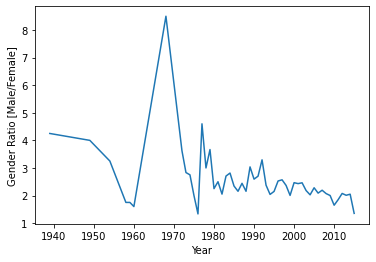

In [5]:
test = train.groupby('Year') 
g1 = test.get_group(1939)
df=train.groupby('Year').sum()
femaleAct = df['Number of female actors']
maleAct = df['Number of male actors']
totAct = femaleAct+maleAct
percMale = maleAct / totAct
percFemale = femaleAct / totAct

ratio = maleAct / femaleAct

plt.plot(df.index,ratio)
plt.xlabel('Year')
plt.ylabel('Gender Ratio [Male/Female]')
#plt.plot(df.index,percFemale)

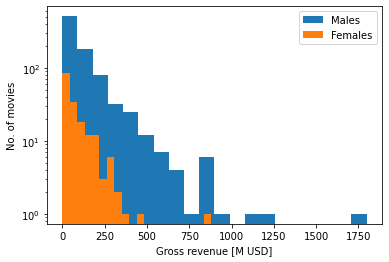

In [6]:
train['wordsFemale'] = train['Number words female'] + (train['Lead'] == 'Female')*train['Number of words lead']
train['wordsMale'] = train['Number words male'] + (train['Lead'] == 'Male')*train['Number of words lead']
train['wordsRatio'] = train['wordsFemale'] / train['wordsMale']
train['mostlyMale'] = train['wordsRatio'] < 1
train['mostlyFemale'] = train['wordsRatio'] > 1
avgFemaleMajority =  (int)(np.mean(train['Gross'][train['mostlyFemale']== True]))
avgMaleMajority =  (int)(np.mean(train['Gross'][train['mostlyMale']== True]))
stdFemaleMajority =  (int)(np.std(train['Gross'][train['mostlyFemale']== True]))
stdMaleMajority =  (int)(np.std(train['Gross'][train['mostlyMale']== True]))
# varFemaleMajority undefined
#print("Female: ",avgFemaleMajority, "Femand STD: ", varFemaleMajority, "Male: ",avgMaleMajority, "Male STD: ", varMaleMajority)
n_bins_male = 20
n_bins_female = 20
num_maleMovies = train['Gross'][train['mostlyMale']== True].count()
num_femaleMovies = train['Gross'][train['mostlyFemale']== True].count()
plt.hist(train['Gross'][train['mostlyMale']== True],bins=n_bins_male)
plt.hist(train['Gross'][train['mostlyFemale']== True],bins=n_bins_female)
plt.yscale('log')
plt.xlabel('Gross revenue [M USD]')
plt.ylabel('No. of movies') 
labels= ["Males","Females"]
plt.legend(labels)

# 4 Implementation of Methods
## 4.1 Methods to explore
The course has (so far) covered the five following ‘families’ of classification methods:

- logistic regression
- discriminant analysis: LDA, QDA
- K-nearest neighbor
- Tree-based methods: classification trees, random forests, bagging
- Boosting

In this project, you decide upon at least as many ‘families’ as you are group members, and decide in
each ‘family’ at least one method to explore. To be clear, **each group member should independently
implement and write about one method.** Who implemented which method should later be clearly
written in the contribution statement. All group members should be able to stand for all sections of
the report.

**Additionally**, you should include a naive classifier that always predicts male as the lead actor in your
analysis and compare its performance with your methods.

*Deep learning, which will be covered later, is also possible to use for classification. You are of course
welcome to explore this as well, in addition to the minimum requirements.*

## 4.2 What to do with each method
For *each* method you decide to explore, you should do the following:

1. Implement the method. We suggest that you use Python, and you may write your own code or use packages (the material from the problem solving sessions can be useful).
2. Tune the method to perform well.
3. Evaluate its performance using, e.g., cross validation. Exactly how to carry this out is up for you to decide.

Once you have completed the aforementioned tasks, you should with a good motivation (hint: cross
validation) select which method you decide to use ‘in production’ on a test set that will be made
available later. **Work on this part of the project together and write the results together.**


## 4.3 Methods



### 4.3.1 Load and scale data

In [22]:
# Load and scale data
train = pd.read_csv('train.csv') # Have to reload since it was altered in data analysis task

X_unscaled = train.drop(columns=['Lead'])
y = train['Lead']

scaler = skl_pre.StandardScaler().fit(X_unscaled)
X = scaler.transform(X_unscaled)

### 4.3.1 Create Naive method

In [57]:
# Naive method
class naiveModel:
    def predict(X_train):
        size = X_train.shape[0]
        res = np.array(['Male']*size)
        return res 
    def fit(a,b):
        a = 0
        return a 

### 4.3.2 Define cross validation function

In [53]:
'''
model_n = 1 for Logistic Regression, 2 for kNN, 31 for Decision Tree max depth, 
32 for Decision Tree leaf_nodes, 33 for Random Forest
''' 
def crossValidation(K, model_n, n_fold = 10):
    cv = skl_ms.KFold(n_splits=n_fold, random_state=2, shuffle=True)
    misclassification = np.zeros(len(K))
    
    for train_index, val_index in cv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
        for j, k in enumerate(K):
            # Might be able to do a dictionary for this
            if (model_n == 1):
                model = skl_lm.LogisticRegression(penalty='l2',C=1/k)
            elif (model_n == 2):
                model = skl_nb.KNeighborsClassifier(n_neighbors=k)
            elif (model_n == 31):
                model = tree.DecisionTreeClassifier(max_depth=k)
            elif (model_n == 32):
                model = tree.DecisionTreeClassifier(max_leaf_nodes=k)
            elif (model_n == 33):
                model = RandomForestClassifier(n_estimators=k, max_leaf_nodes=30)
            elif (model_n == 99):
                model = naiveModel
            
            model.fit(X_train, y_train)
            prediction = model.predict(X_val)
            misclassification[j] += np.mean(prediction != y_val)
    misclassification /= n_fold

    return misclassification

### 4.3.3 Logistic regression

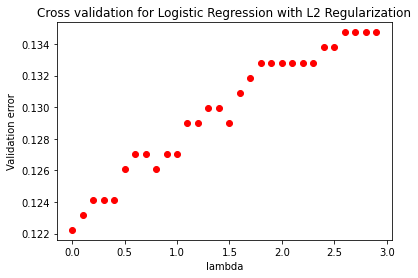

In [9]:
lamda_values = np.arange(0.00001,3,0.1)
misclassification = crossValidation(lamda_values, 1)

plt.figure()
plt.plot(lamda_values, misclassification,'ro',label='val error')
plt.title('Cross validation for Logistic Regression with L2 Regularization')
plt.xlabel('lambda')
plt.ylabel('Validation error')
plt.show()

In [18]:
def class_error(y,yt):
    fmask = (y == yt)
    classific = np.zeros(len(y))
    classific[fmask] = 1
    classific[~fmask]= 0
    return np.mean(1-classific)
    
lamda = 0.0001
Creg = 1/lamda

log_reg = skl_lm.LogisticRegression(penalty='l2',C=Creg)

log_reg.fit(X,y)

Ypred_train = log_reg.predict(X) 

print("Regularization lambda=",lamda)
print("train error    ", class_error(y,Ypred_train))
print('alt train error',np.mean(Ypred_train!=y))
print("train accuracy ", log_reg.score(X,y))

['Female' 'Male' 'Male' ... 'Male' 'Male' 'Male']
Regularization lambda= 0.0001
train error     0.12127045235803657
alt train error 0.12127045235803657
train accuracy  0.8787295476419634


### 4.3.4 kNN 

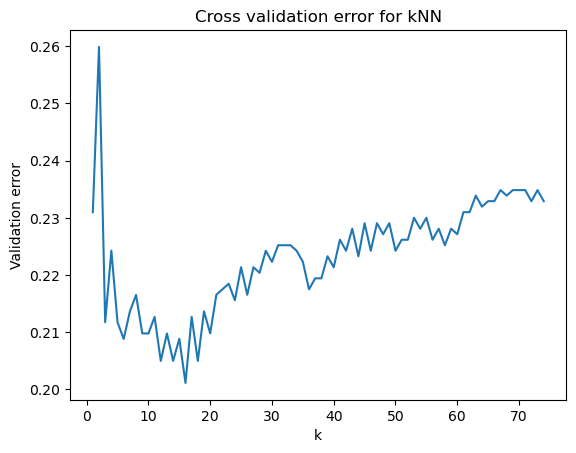

In [10]:
K = np.arange(1,75)
misclassification = crossValidation(K, model_n = 2)
plt.plot(K, misclassification)
plt.title('Cross validation error for kNN')
plt.xlabel('k')
plt.ylabel('Validation error')
plt.show()

In [11]:
for k in range(5,25):
    model = skl_nb.KNeighborsClassifier(n_neighbors=k)
    model.fit(X, y)
    prediction = model.predict(X)
    print("--------------------")
    print("kNN with k =", k)
    print(pd.crosstab(prediction, y))
    print(f"Accuracy: {np.mean(prediction == y):.3f}")

--------------------
kNN with k = 5
Lead    Female  Male
row_0               
Female     124    22
Male       130   763
Accuracy: 0.854
--------------------
kNN with k = 6
Lead    Female  Male
row_0               
Female     160    38
Male        94   747
Accuracy: 0.873
--------------------
kNN with k = 7
Lead    Female  Male
row_0               
Female     107    14
Male       147   771
Accuracy: 0.845
--------------------
kNN with k = 8
Lead    Female  Male
row_0               
Female     135    31
Male       119   754
Accuracy: 0.856
--------------------
kNN with k = 9
Lead    Female  Male
row_0               
Female      91    16
Male       163   769
Accuracy: 0.828
--------------------
kNN with k = 10
Lead    Female  Male
row_0               
Female     111    25
Male       143   760
Accuracy: 0.838
--------------------
kNN with k = 11
Lead    Female  Male
row_0               
Female      81    15
Male       173   770
Accuracy: 0.819
--------------------
kNN with k = 12
Lead    F

### 4.3.5 Trees

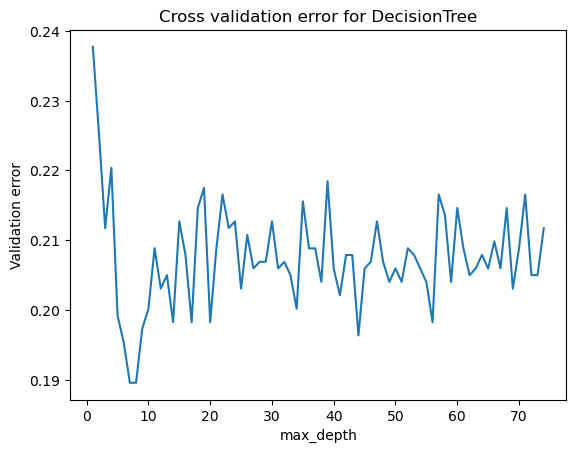

In [12]:
# Decision trees, max depth

np.random.seed(1)


K = np.arange(1,75)
misclassification = crossValidation(K, model_n = 31)

plt.plot(K, misclassification)
plt.title('Cross validation error for DecisionTree')
plt.xlabel('max_depth')
plt.ylabel('Validation error')
plt.show()


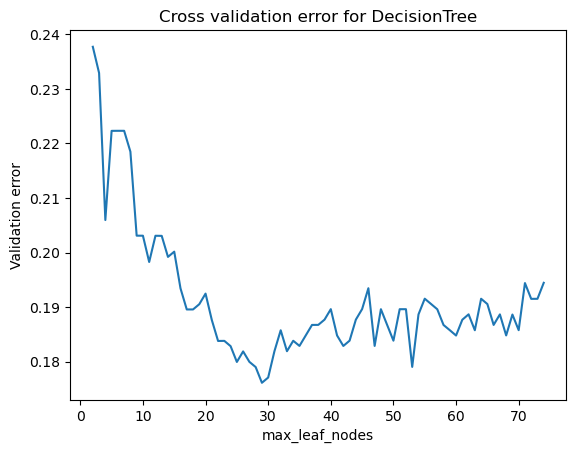

In [13]:
# Decision trees, leaf-nodes

np.random.seed(1)
K = np.arange(2, 75)
misclassification = crossValidation(K, model_n = 32)

plt.plot(K, misclassification)
plt.title('Cross validation error for DecisionTree')
plt.xlabel('max_leaf_nodes')
plt.ylabel('Validation error')
plt.show()

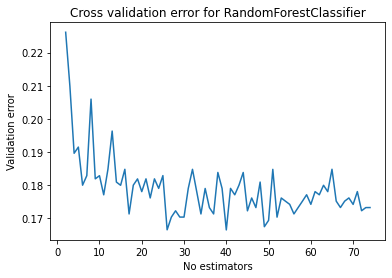

In [17]:
# Random Forest
np.random.seed(1)
K = np.arange(2, 75)
misclassification = crossValidation(K, model_n = 33)

plt.plot(K, misclassification)
plt.title('Cross validation error for RandomForestClassifier')
plt.xlabel('No estimators')
plt.ylabel('Validation error')
plt.show()

### 4.5.3.1 Bagging

In [ ]:
np.random.seed(1)
# Create array of classifiers to test bagging
classifierName = [tree.DecisionTreeClassifier(max_depth=7),
                  tree.DecisionTreeClassifier(max_leaf_nodes=30),
                  RandomForestClassifier(n_estimators=50)]

# n-fold runs
n_fold = 10
cv = skl_ms.KFold(n_splits=n_fold, random_state=2, shuffle=True)
K = np.arange(2, 75)
misclassification = np.zeros((len(classifierName), len(K))) 
# run all models and save for subplot
for m in np.arange(len(classifierName)):
    print(m)
    # run for all splits
    for train_index, val_index in cv.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train model on split
        for j, k in enumerate(K):
            model = BaggingClassifier(
                base_estimator=classifierName[m],
                n_estimators=k)
            model.fit(x_train, y_train)
            prediction = model.predict(x_val)
            misclassification[m, j] += np.mean(prediction != y_val)
            # if the tree-structure is of interest
            # dot_data = tree.export_graphviz(model,
            #                                 out_file=dir + "None_" + str(i),
            #                                feature_names=X_train.columns,
            #                                class_names=model.classes_,
            #                                filled=True,
            #                                rounded=True,
            #                                leaves_parallel=True,
            #                                proportion=True)

            # graph = graphviz.Source(dot_data)
    print(m)

# Plot cross-val-error per method, assuming three models, change if necessary
misclassification /= n_fold
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(K, misclassification[0, :])
ax1.set_title('DT max_d = 7')
ax1.set(xlabel='', ylabel='Validation error')
ax2.plot(K, misclassification[1, :])
ax2.set_title('DT max_leaf = 30')
ax2.set(xlabel='n_estimators', ylabel='')
ax3.plot(K, misclassification[2, :])
ax3.set_title('RFC n_est = 50')
ax3.set(xlabel='', ylabel='')
fig.set_figwidth(20)
plt.show()

0


### 4.5.3.1 Naive classifier

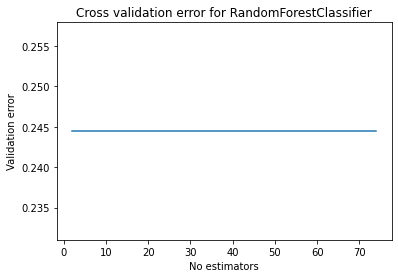

In [58]:
# Naive classifier
np.random.seed(1)
K = np.arange(2, 75)
misclassification = crossValidation(K, model_n = 99)

plt.plot(K, misclassification)
plt.title('Cross validation error for RandomForestClassifier')
plt.xlabel('No estimators')
plt.ylabel('Validation error')
plt.show()